In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re
import jieba as jb
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
# from IPython.core.interactiveshell import InteractiveShell  
# InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False


In [2]:
df = pd.read_csv( './data/sogou2006_clean.csv')
len(df)
df.sample(10)

,text,label,cat
16631,\r\r\n\r\r\n\r\r\n\r\r\n\r\r\n\r\r\n 中新网2月14日...,C000024,军事
2658,\r\r\n 视频上传网站YouTube.COM酝酿卖广告，瞄准规模125亿美元的广告市场...,C000010,科技
15608,这些年，总有一些事让我很矛盾：期待，又担心。\r\r\n 今年的春晚《千手观音》，就是...,C000023,历史
14076,母语地位上升需求回暖 \r\r\n 本报北京3月17日电（记者袁晓露）北京师范大学出版...,C000023,历史
15992,\r\r\n\r\r\n\r\r\n美空军作战型CV-22“鱼鹰”倾转旋翼机\r\r\n ...,C000024,军事
10611,\r\r\n １８０３年英国化学家道尔顿（１７６６－１８４４）提出原子论后，受到科学界的普...,C000020,教育
1479,"河北宣工(行情,论坛)（000923）：外资合作 涨停专家\r\r\n第一证券\r\r\n...",C000008,财经
3386,【eNet特约评论】昔日在电信领域红极一时的朗讯，在市场的残酷冲击下，锐气不及当年。朗讯...,C000010,科技
6320,新华社照片，东京，2006年5月7日 （体育）（5）羽毛球――中国男队勇夺汤姆斯杯 ...,C000014,体育
13586,眉目传神热情自信\r\r\n 一般说来，眼睛会表现出自卑和自信、诚实和伪装。在你进门之...,C000022,人力资源


In [3]:
df.cat.value_counts()

旅游      1990
军事      1990
财经      1990
科技      1990
人力资源    1990
教育      1990
体育      1990
健康      1990
历史      1989
Name: cat, dtype: int64

In [4]:
df[df.cat=='财经'].sample(1).text.values[0]

'    证券通：计划向外资定向增发 G苏阳光(行情,论坛)将继续高增长\r\r\n\r\r\n    深度报告 权威内参 来自“证券通”www.KL178.com\r\r\n\r\r\n  G苏阳光（600220）主要从事精纺呢绒和西服的生产和销售，目前具有年产2000万米呢绒，150万套服装的生产能力，是国内最大的精纺呢绒生产企业，毛纺行业的龙头企业。\r\r\n\r\r\n  查阅《证券通－第一内参》可知，公司计划向2-3家外资企业定向增发1亿股－2亿股，5月后进入实质谈判阶段。公司05年EPS为0.018元，预计06年EPS达到0.114元，同比增长525.5%。假设引入外资成功，07年后业绩继续稳步增长，07年、08年净利润分别同比增长28.3%和27.3%。受此影响，G苏阳光5月8日开盘后没多久便被大单封涨停。\r\r\n\r\r\n  更多详情免费咨询021*64690729或登录WWW.KL178.COM（证券通），资深行业研究员为您提供客观、深度、超前的投资信息。\r\r\n\r\r\n    本文版权为“证券通”独家拥有，任何单位和个人不得复制、转发以及用于业务经营，违者将追究其法律责任。作者声明：在本机构、本人所知情的范围内,本机构、本人以及财产上的利害关系人与所述文章内容没有利害关系。本版文章纯属个人观点,仅供参考,文责自负。读者据此入市,风险自担。'

In [5]:
df[df.cat=='旅游'].sample(1).text.values[0]

'\r\r\n&nbsp;\r\r\n\u3000\u3000主要聚居在地处黄河沿岸的青海[图库]省循化地区。撒拉族有自已的语言，但无文字，通用汉文。撒拉语属阿尔泰语系突厥语族，吸收了不少汉语和藏语词汇，青壮年多通汉语。 \u3000\u3000撒拉族男儿，多以上山伐木、下河板筏为生。此外，养蜂是撒拉人最喜爱的副业生产，园艺也是他们的特长。\r\r\n&nbsp;&nbsp;&nbsp; 习俗\r\r\n\u3000\u3000撒拉族的禁忌有：忌食猪肉、狗肉、驴肉、骡肉和死的畜禽肉及动物的血；严禁在清真寺内及其附近地吐痰或携带污浊之物进入清真寺；作礼拜时，他人不得从面前走过；忌在水井、水塘附近洗涤衣物；与人谈话时忌咳嗽和擤鼻涕；在老人面前不能有失礼的行为。\r\r\n&nbsp;&nbsp;&nbsp; 婚俗\r\r\n\u3000\u3000在新娘上路之前，女方的家长要用做好的比利买海和上好的茶水招待迎送新娘的客人。看望妇女坐月子，都要带上比利买海，请产妇滋补身体。孩子出满月，主人要拿出核桃、大枣和把薄面片切成正方形或菱形小块油炸成一种名为“古古麻麻”的食品，散发给来祝贺的客人。\r\r\n&nbsp;&nbsp;&nbsp; 食俗\r\r\n\u3000\u3000撒拉族习惯于日食三餐（农忙时根据情况适当加餐），主食以面粉为主。家常品种有花卷、馍馍、馒头、烙饼、面片、拉面、擀面、散饭、搅团等。在一年一度的斋月里，一般都只食早、晚两餐，饭菜比平时丰盛一些。\u3000\u3000按照伊斯兰教义，撒拉族严禁饮酒，一般在撒拉族的筵席上不备酒。平时更无饮酒的习惯。 日常饮料除清茶、奶茶和盖碗茶以外，还常饮麦茶和果叶茶。制作麦茶时，将麦粒炒焙半焦捣碎后，加盐和其他配料，以陶罐熬成，味道酷似咖啡，香甜可口；果叶茶是用晒干后炒成半焦的果树叶子制成，饮用别具风味。\u3000\u3000典型食品：比利买海，又称“油搅团”，撒拉族传统风味食品，用植物油、面粉制成。\r\r\n&nbsp;&nbsp;&nbsp; 节庆\r\r\n\u3000\u3000撒拉人信奉伊斯兰教。主要节日有开斋节、古尔邦节等。最大的传统节日为古尔邦节，每当节日来临，撒拉族都要宴请宾客，煮手抓羊肉，炖鸡肉，做糖包、油炸蛋糕、炸馓子，做“比利买海”（油搅团）、“木丝日”（一种以油、熟面等为馅的包子）和各种烩菜

In [6]:
df[df.cat=='健康'].sample(1).text.values[0]

'\u3000\u3000在河南灵宝市，全市有百分之八十八点五的农民参加合作医疗，不到一年时间，补助农民医疗金额达一百二十九万元，新型农村合作医疗为农民带来的实惠早已有目共睹。\r\r\n\u3000\u3000四月二十六日，记者在河南省灵宝市阳平镇卫生院看到，四十岁的申花伴从灵宝市委宣传部张成宝部长和卫生局局长马宽荣手里接过了七千六百元钱。原来，两个月前，她的丈夫杨明祥被烧伤，在卫生院住院用了两万多元，因为参加了灵宝市新型农村合作医疗，象这种情况，能报销百分之四十的医药费。因此，申花伴领到了这七千多元钱。\r\r\n\u3000\u3000据介绍，二OO五年年底，灵宝市被确定为河南省新型农村合作医疗第二批试点县(市)，截止到四月十五日，全市参加合作医疗的农民已达到了五十二万多人，占全市农业总人口五十九点二万人的百分之八十八点五，全市共补助参合农民四万两千多人，补助金额一百二十九万元。灵宝市的农村合作医疗的初见成效，明显缓解了农民看病难、看病贵问题。'

In [7]:
df[df.cat=='军事'].sample(1).text.values[0]

'\u3000\u3000作者简介:于汝波，军事科学院战争理论和战略研究部少将研究员，博士生导师，中国孙子兵法研究会副会长。出版《大思维——解读中国古典战略》等著作数十种，发表论文百余篇。作品曾获国家图书奖、“五个一工程”奖等多项奖励。\r\r\n\u3000\u3000编者按\u3000胡锦涛主席在全国科学技术大会上号召走中国特色自主创新道路，建设创新型国家；大力推进理论创新、制度创新、科技创新。要求在关系国计民生和国家安全的关键领域，集中力量、重点突破，实现跨越式发展。这是从当前世界情势、我国目前实际和长远目\r\r\n\u3000\u3000标出发，做出的重大战略决策。使命召唤我们必须要在自主创新上当尖兵，尽快把我军建设成一支创新型军队。历史是一面镜子，前事不忘，后事之师，我国历史上在军事创新方面有着丰富而深刻的经验教训，总结这些经验教训，对我们今天少走弯路，实现创新型国家的宏伟目标，无疑具有积极意义。\r\r\n\u3000\u3000我国从春秋到明代前期2000多年的时间里，军事科技一直在世界上处于领先地位。但在16世纪之后，我们却逐步落后于西方，军队的战斗力也因此大为下降。从军事科技的角度认真剖析其中的原由，对于我们今天仍有深刻的启迪。\r\r\n\u3000\u3000近代中国封闭的环境窒息了国人的创新思维\r\r\n\u3000\u3000导致国人创新思维萎缩的环境因素主要指落后的社会制度、闭关锁国的国策等。\r\r\n\u3000\u3000首先，近代中国落后的社会制度压制了国人的创新思维。西方在16世纪发生了资产阶级革命，快速兴起的资本主义工商业对科学技术不断提出新的需求，从而激活了人们的创新思维，促进了科学技术的创新。而当时的中国却仍然停留在更加完善的封建主义社会，它不但严重限制工商业的发展，而且在思想领域压制新生事物，扼杀创新思维。为了维护其既得利益，统治阶级内部的保守势力往往留恋过去，反对变革，这是阻碍国人创新思维发展的一块大绊脚石。\r\r\n\u3000\u3000其次，国家实行封闭政策不利于国人创新思维的发展。中外历史证明，国家只有开放，才能使国人获得多方面的新信息，产生认识上的飞跃，创造出新的科技成果。西方的军事科技正是在这样的背景和基础上迅猛发展起来的。而当时中国的统治者，实行严密封闭的愚民政策。行政封闭和思想禁锢使中国与国外缺乏

In [8]:
df[df.cat=='历史'].sample(1).text.values[0]

'\r\r\n\u3000\u3000可见出检察机关的问题来了吗？这个问题就是检察机关对整个案件侦查的无控制，这是不符合大陆法系基本精神的。公安局（警察局）是国家的治安机构，隶属于国家的行政系统，由于治安案件与刑事案件通常只是量（程度）的差异，因此，公安局（警察局）就自然转化为了刑事案件的侦查机构。但是，这两者有着很重要的区别，当其作为治安机构时，可以独立行使行政处罚权；当其作为刑事案件的侦查机构时，必须由刑事法庭进行判决，公安局（警察局）不具有处罚权。因此，在大陆法系，刑事案件的侦查就要由检察官进行控制、指挥、策划、监督，从立案到起诉保持连贯性、统一性，既是保证起诉质量的必要，也是对全社会刑事犯罪进行统一、有效打击的需要。也就是说，检察官是刑事案件侦查的核心，而不是质量检验员。在以大陆法系为形式的国家，由于法官本不控制刑事侦查，当检察官又不能控制刑事侦查时，整个国家的刑事侦查体系就成为了无控制的独立王国，轻则走向独立专横，重则导致国家警察化。在中国，至今仍然在制度上保证着公安局刑事侦查的独立专横，比如，人们越来越意识到具有违宪倾向的劳动教养制度，从刑事侦查角度说，就是赋予了公安局以独立于两院的“判决权”：公安局可以借此对可能只要判三两年甚至更高刑期的嫌犯绕开两院进行实际的刑罚处理。\r\r\n\u3000\u3000检察机关权力的弱化，既导致了公安局刑事侦查人员业务能力的低下，也导致了检察机关自身业务能力的低下。随着中国律师队伍业务能力的提高，这一矛盾将越来越显示出来。田文昌在刘涌一案里的“自由”发挥，其根源即在于此。但是，这一情况并不是中国律师的喜讯，因为，为了最大可能保证案犯得到“应有的”惩罚，中国的律师也将受到越来越多的行政、法律打压。我可以下一个不受各方欢迎的结论：中国律师业务水平的提高一定与律师的被关押、判刑数量成正比。十多年前我侦破上海（也可能是中国）第一例律师受贿罪案，情况是该律师掌握某发电厂的合同最终审批签字权（从法律上认可合同的有效性并决定合同的可实施），他凭该权力向客户索取贿赂。可现在被拘捕的律师都是什么罪名呢？就不能细讨论了。因此，不仅律师业务水平的提高将受到抑制，而且将诱致律师队伍趋向腐败。律师队伍腐败的一个重要项目，就是跟一些不自重的法官瓜分收益，从而又导致法官队伍出现腐败。“我们跟这个法院的关系很好，搞得定”，这是现在不少律师事务所最喜

In [9]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
 
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  
 
#加载停用词
stopwords = stopwordslist("./data/chineseStopWords.txt")


In [10]:
df['text_clean'] = df['text'].apply(remove_punctuation)
df.sample(10)

,text,label,cat,text_clean
6031,\r\r\n 夺冠呼声消失殆尽后，申花队似乎陷入了难以自拔的沉默期。客场挑战西安国际0比0...,C000014,体育,夺冠呼声消失殆尽后申花队似乎陷入了难以自拔的沉默期客场挑战西安国际0比0互交白卷主场又与北京...
2057,神州奥美向其子公司索赔1.2亿元，盛大首次申明没有侵权\r\r\n 本报讯 昨天，针对...,C000010,科技,神州奥美向其子公司索赔12亿元盛大首次申明没有侵权本报讯昨天针对神州奥美12亿元的天价索赔案...
5219,\r\r\n 减肥不减腿部脂肪，因为它可以减少患心脏病的危险，这是日本筑波大学人类综合科学...,C000013,健康,减肥不减腿部脂肪因为它可以减少患心脏病的危险这是日本筑波大学人类综合科学研究专业讲师大藏伦博...
9637,“人们在这里寻找到一种爱的精神，对爱的向往、对爱的恪守，这就足够了。因为爱是人类最本质的...,C000016,旅游,人们在这里寻找到一种爱的精神对爱的向往对爱的恪守这就足够了因为爱是人类最本质的东西有了它幸福...
17289,\r\r\n\r\r\n\r\r\n\r\r\n 美国《航空周刊》2006年3月27日刊报...,C000024,军事,美国航空周刊2006年3月27日刊报道JUCAS联合无人空战系统项目下马后美国军方企业界和有...
9435,还没踏出火车站，就看到李奥纳多·迪卡普里奥的大型海报，原来当地正举办摄影展，展出许多电影拍摄...,C000016,旅游,还没踏出火车站就看到李奥纳多迪卡普里奥的大型海报原来当地正举办摄影展展出许多电影拍摄之余所抓...
14491,\r\r\n 沈奕斐：在上海医药仓库里所存的那些盘尼西林，原来是准备给抗美援朝的志愿军的。...,C000023,历史,沈奕斐在上海医药仓库里所存的那些盘尼西林原来是准备给抗美援朝的志愿军的但是治疗性病如果没有这...
3553,4月4日，信息产业部正式发布了25个《数字电视接收设备标准》。新科系列时尚液晶电视（DT...,C000010,科技,4月4日信息产业部正式发布了25个数字电视接收设备标准新科系列时尚液晶电视DTV460DTV...
13223,11月12日上午，4700多名应届毕业生参加了在新校区举办的天津师范大学2006届毕业生...,C000022,人力资源,11月12日上午4700多名应届毕业生参加了在新校区举办的天津师范大学2006届毕业生就业洽...
12823,这是电影《英雄》中的“十步一杀”：\r\r\n 四周是成捆的竹简，无名拿出一根竹简标出...,C000022,人力资源,这是电影英雄中的十步一杀四周是成捆的竹简无名拿出一根竹简标出记号示意是秦王要害部位无名回身迈...


In [11]:
df['text_cut'] = df['text_clean'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df.sample(10)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.748 seconds.
Prefix dict has been built successfully.


,text,label,cat,text_clean,text_cut
3813,\r\r\n 一家美国上市公司的中国概念与纸上并购\r\r\n 本报记者 柯志雄\r\r...,C000010,科技,一家美国上市公司的中国概念与纸上并购本报记者柯志雄北京报道在高个白人中佛罗里达狼是少数常来中...,一家 美国 上市公司 中国 概念 纸 并购 本报记者 柯志雄 北京 报道 高个 白人 中 佛...
7700,五大前锋轮番上阵，申花仍旧没有摆脱锋线零进球的尴尬。昨天晚上，济南的体育场，申花在场面明...,C000014,体育,五大前锋轮番上阵申花仍旧没有摆脱锋线零进球的尴尬昨天晚上济南的体育场申花在场面明显占优的情况...,五大 前锋 轮番上阵 申花 没有 摆脱 锋线 零 进球 尴尬 昨天晚上 济南 体育场 申花 ...
14812,\r\r\n 叶剑英在粉碎“四人帮”的斗争中起到了决定性的作用，赢得了党内外的高度评价。华...,C000023,历史,叶剑英在粉碎四人帮的斗争中起到了决定性的作用赢得了党内外的高度评价华国锋认为叶剑英德高望重建...,叶剑英 粉碎 四人帮 斗争 中 起到 决定性 作用 赢得 党内外 高度评价 华国锋 认为 叶...
16103,目前，对于信息化战争的研究，多数是从战争形态的角度，从宏观上，以信息化战争的基本概念、基...,C000024,军事,目前对于信息化战争的研究多数是从战争形态的角度从宏观上以信息化战争的基本概念基本特征作战方式...,目前 信息化 战争 研究 多数 是从 战争 形态 角度 宏观 上以 信息化 战争 基本概念 ...
13814,因为跳槽到同行业其他公司，杨女士被原单位告上法庭，日前，一中院以杨女士违反竞业禁止约定为...,C000022,人力资源,因为跳槽到同行业其他公司杨女士被原单位告上法庭日前一中院以杨女士违反竞业禁止约定为由终审判决...,跳槽 同行业 公司 杨 女士 原 单位 告上 法庭 日前 一中院 杨 女士 违反 竞业禁止 ...
9937,\r\r\n 红色旅游正在全国如火如荼地展开，井冈山、韶山、遵义、延安、西柏坡等几大革命圣...,C000016,旅游,红色旅游正在全国如火如荼地展开井冈山韶山遵义延安西柏坡等几大革命圣地迎来了源源不断的客流成为...,红色旅游 正在 全国 如火如荼 展开 井冈山 韶山 遵义 延安 西柏坡 几大 革命圣地 迎来...
10149,本报讯（记者 石果 实习生 罗智渊）昨日，记者从西南政法大学获悉，5月2日我市将首次举行...,C000020,教育,本报讯记者石果实习生罗智渊昨日记者从西南政法大学获悉5月2日我市将首次举行2006年司法考试...,本报讯 记者 石果 实习生 罗智渊 昨日 记者 西南政法大学 获悉 月 日 我市 首次 举行...
5702,今年3月1日，可以说是我国药品生产企业试点参数放行的“起跑线”。这一天，国家食品药品监督...,C000013,健康,今年3月1日可以说是我国药品生产企业试点参数放行的起跑线这一天国家食品药品监督管理局SFDA...,今年 月 日 说 我国 药品 生产 企业 试点 参数 放行 起跑线 一天 国家 食品 药品监...
8516,新华网成都４月２９日专电（记者肖林）记者２９日从成都铁路局获悉，成渝城际旅客双层新型空调...,C000016,旅游,新华网成都月日专电记者肖林记者日从成都铁路局获悉成渝城际旅客双层新型空调列车将于月日正式开行...,新华网 成都 月 日 专电 记者 肖林 记者 日 成都 铁路局 获悉 成渝 城际 旅客 双层...
15563,70年代，家里有辆自行车是件很有面子的事情，记得那时最好的牌子叫凤凰，当然更考究的要骑蓝...,C000023,历史,70年代家里有辆自行车是件很有面子的事情记得那时最好的牌子叫凤凰当然更考究的要骑蓝翎那是英国...,70 年代 家里 有辆 自行车 件 面子 事情 记得 最好 牌子 凤凰 更 考究 骑 蓝翎 ...


In [12]:
sentences = [row.split() for row in df['text_cut']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)


297176

In [13]:
model = Word2Vec(min_count=200,
                     window=5,
                     size=100,
                     workers=4)

model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)
model.init_sims(replace=True)

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).



In [14]:
model.wv.most_similar(positive=['基金'])

[('股票', 0.5983016490936279),
 ('债券', 0.5910301208496094),
 ('认购', 0.5515949726104736),
 ('投资者', 0.5413485169410706),
 ('投资', 0.5206654071807861),
 ('持股', 0.5060251355171204),
 ('招商', 0.5032355785369873),
 ('券商', 0.49891117215156555),
 ('评级', 0.4926179051399231),
 ('现金', 0.46198245882987976)]

In [15]:
model.wv.most_similar(positive=['感冒'])

[('咳嗽', 0.8751150369644165),
 ('过敏', 0.8337826728820801),
 ('出血', 0.8206079602241516),
 ('发作', 0.8174974322319031),
 ('不适', 0.7918287515640259),
 ('疼痛', 0.7878854274749756),
 ('头痛', 0.7779319286346436),
 ('服用', 0.769497811794281),
 ('干燥', 0.7627055048942566),
 ('失眠', 0.7600494623184204)]

In [16]:
model.wv.most_similar(positive=['失业'])

[('劳动力', 0.555505633354187),
 ('负担', 0.5551137328147888),
 ('人口', 0.5382763743400574),
 ('贫困', 0.5218415260314941),
 ('子女', 0.5126364827156067),
 ('就业', 0.5091021656990051),
 ('困扰', 0.4945515990257263),
 ('农民工', 0.49445784091949463),
 ('绝大多数', 0.48268261551856995),
 ('生育', 0.46601128578186035)]

In [17]:
model.wv.most_similar(positive=['宾馆'])

[('饭店', 0.8367468118667603),
 ('旅馆', 0.7565426230430603),
 ('大厦', 0.7466408610343933),
 ('地铁', 0.7440853118896484),
 ('店', 0.7361814379692078),
 ('餐厅', 0.7339795231819153),
 ('豪华', 0.7255125641822815),
 ('码头', 0.7242347002029419),
 ('酒店', 0.7172418832778931),
 ('住宿', 0.6967345476150513)]

In [18]:
model.wv.most_similar(positive=['F35'])

[('猛禽', 0.7212422490119934),
 ('战斗机', 0.6596713662147522),
 ('美国空军', 0.6593104600906372),
 ('款', 0.6327800750732422),
 ('无人机', 0.6288824677467346),
 ('下一代', 0.6235269904136658),
 ('隐形', 0.6190775036811829),
 ('Windows', 0.6013031005859375),
 ('F16', 0.5972725749015808),
 ('芯片', 0.5969035625457764)]

In [19]:
model.wv.most_similar(positive=['蒋介石'])

[('国民党', 0.8251262903213501),
 ('周恩来', 0.7420367002487183),
 ('长官', 0.7394211292266846),
 ('遂', 0.7065316438674927),
 ('孙中山', 0.7047836184501648),
 ('中共', 0.6950869560241699),
 ('邓小平', 0.6865406036376953),
 ('司令', 0.6803985834121704),
 ('共产党', 0.6637289524078369),
 ('台当局', 0.6634297370910645)]

In [20]:
model.wv.similarity('蒋介石', '校长')

0.36402318

In [21]:
model.wv.similarity('蒋介石', '汽车')

-0.13398343

In [22]:
df_small, _ = train_test_split(df, test_size=0.85)

sentences = [row.split() for row in df_small['text_cut']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
print(len(word_freq))

107311


In [23]:
w2v_model = Word2Vec(min_count=200,
                     window=5,
                     size=100,
                     workers=4)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)
w2v_model.init_sims(replace=True)

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).



d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



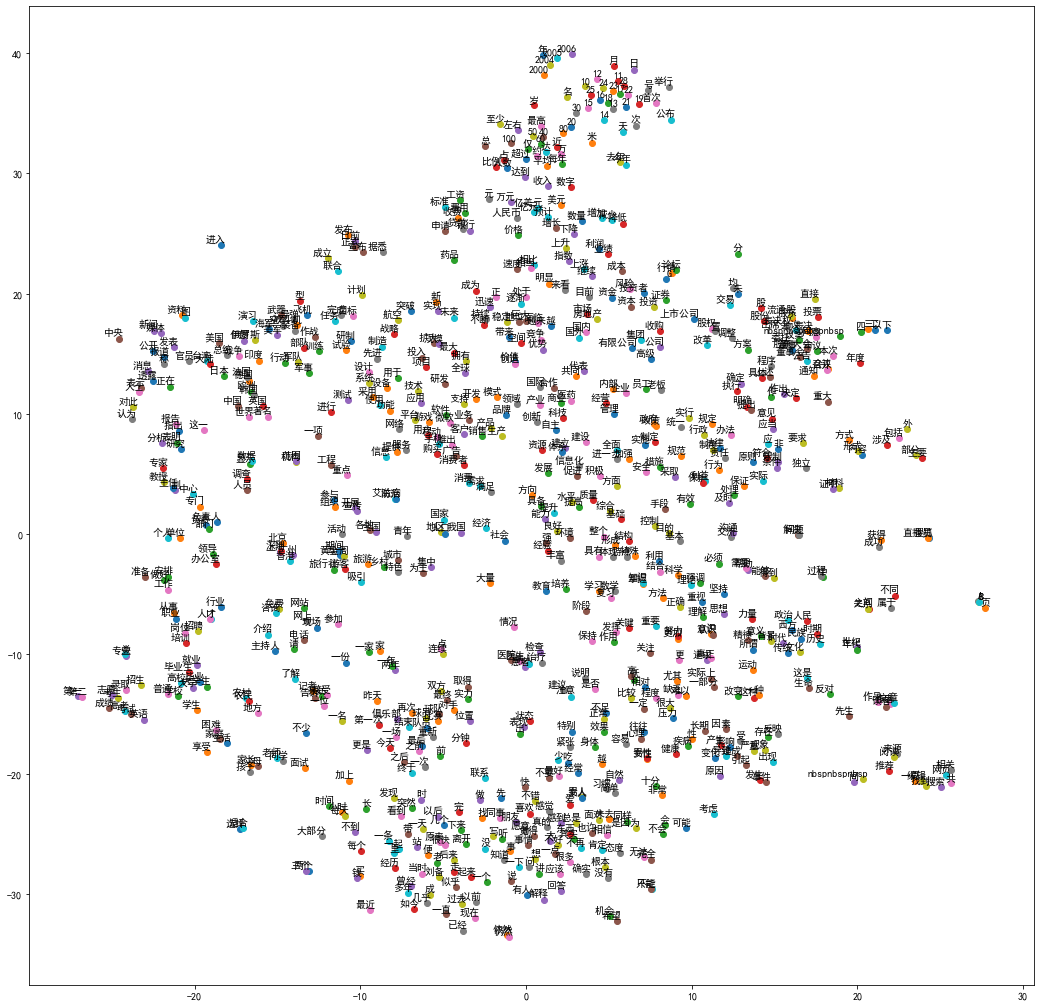

In [24]:
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot(w2v_model)

In [44]:
model_wv_df = pd.DataFrame(model[model.wv.vocab], list(model.wv.vocab))
keywords = ["行情", "旅游", "手机", "股权","基金", "招聘", "高考", "分析","录取", \
            "学生", "员工", '军事', '老板', '战争','国际', '服务',"健康","地区",\
           "俄罗斯","台湾","中国","董事会","风险","部队"]
words = [word for word in keywords if word in list(model.wv.vocab)]

X = model_wv_df.T[words].T
pca = PCA(n_components=2)
result = pca.fit_transform(X)

df = pd.DataFrame(result, columns=["Component 1", "Component 2"])
df["Word"] = keywords
df["Distance"] = np.sqrt(df["Component 1"]**2 + df["Component 2"]**2)
fig = px.scatter(df, x="Component 1", y="Component 2", text="Word", color="Distance", color_continuous_scale="agsunset",size="Distance")
fig.update_traces(textposition='top center')
fig.layout.xaxis.autorange = True
fig.data[0].marker.line.width = 1
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.update_layout(height=800,  template="plotly_white", paper_bgcolor="#f0f0f0")
fig.show()

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

